<a href="https://colab.research.google.com/github/javaria-gul/Smart-City-AQI-Prediction-ML/blob/main/Air_Quality_Prediction_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests pandas numpy matplotlib seaborn scikit-learn xgboost openaq openweathermap-api

!pip install python-dotenv

ERROR: Could not find a version that satisfies the requirement openweathermap-api (from versions: none)
ERROR: No matching distribution found for openweathermap-api


In [2]:

OWM_API_KEY = "key"

In [3]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

# Function to get weather data from OpenWeatherMap
def get_weather_data(city="Karachi", days=60):
    """
    Fetch historical weather data for specified city
    Note: OpenWeatherMap free tier only has current and forecast
    For historical, we'll use their current API and collect daily
    For actual assignment, consider using their One Call API 3.0
    """
    weather_data = []

    print("Collecting weather data...")

    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    for single_date in dates:
        day_data = {
            'date': single_date.strftime('%Y-%m-%d'),
            'temperature': np.random.uniform(20, 35),  # °C
            'humidity': np.random.uniform(40, 90),     # %
            'pressure': np.random.uniform(1000, 1020), # hPa
            'wind_speed': np.random.uniform(0, 10),    # m/s
            'city': city
        }
        weather_data.append(day_data)

    weather_df = pd.DataFrame(weather_data)
    print(f"Weather data collected: {len(weather_df)} records")
    return weather_df
def get_air_quality_data(city="Karachi", days=60):
    """
    Fetch air quality data from OpenAQ API
    """
    print("Collecting air quality data...")

    url = "https://api.openaq.org/v2/measurements"

    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    parameters = ['pm25', 'pm10', 'no2', 'o3', 'so2', 'co']
    aq_data = []

    for param in parameters:
        try:
            # API parameters
            params = {
                'country': 'PK',
                'parameter': param,
                'date_from': start_date.strftime('%Y-%m-%d'),
                'date_to': end_date.strftime('%Y-%m-%d'),
                'limit': 10000,
                'page': 1
            }

            response = requests.get(url, params=params)

            if response.status_code == 200:
                data = response.json()
                for result in data.get('results', []):
                    record = {
                        'date': result['date']['utc'].split('T')[0],
                        'parameter': result['parameter'],
                        'value': result['value'],
                        'unit': result['unit'],
                        'city': result.get('city', 'Unknown')
                    }
                    aq_data.append(record)

            time.sleep(0.5)

        except Exception as e:
            print(f"Error fetching {param}: {e}")

    if not aq_data:
        print("No real data fetched. Creating synthetic data for demonstration...")

        aq_data = create_synthetic_aq_data(days)

    aq_df = pd.DataFrame(aq_data)
    print(f"Air quality data collected: {len(aq_df)} records")
    return aq_df

def create_synthetic_aq_data(days=60):
    """Create synthetic air quality data for assignment"""
    synthetic_data = []
    end_date = datetime.now()

    for i in range(days):
        date = (end_date - timedelta(days=i)).strftime('%Y-%m-%d')
        base = np.random.normal(50, 20)

        pollutants = {
            'date': date,
            'pm25': max(0, base + np.random.normal(0, 10)),
            'pm10': max(0, base * 1.2 + np.random.normal(0, 15)),
            'no2': max(0, base * 0.8 + np.random.normal(0, 8)),
            'o3': max(0, base * 0.6 + np.random.normal(0, 5)),
            'so2': max(0, base * 0.4 + np.random.normal(0, 3)),
            'co': max(0, base * 0.1 + np.random.normal(0, 1)),
            'city': 'Karachi'
        }

        for param, value in pollutants.items():
            if param not in ['date', 'city']:
                synthetic_data.append({
                    'date': date,
                    'parameter': param,
                    'value': value,
                    'unit': 'µg/m³',
                    'city': 'Karachi'
                })

    return synthetic_data
print("="*50)
print("STARTING DATA COLLECTION")
print("="*50)

weather_df = get_weather_data(city="Karachi", days=60)
aq_df = get_air_quality_data(city="Karachi", days=60)

print("\nWeather Data Sample:")
print(weather_df.head())
print(f"\nWeather Data Shape: {weather_df.shape}")

print("\nAir Quality Data Sample:")
print(aq_df.head())
print(f"\nAir Quality Data Shape: {aq_df.shape}")

STARTING DATA COLLECTION
Weather data collected: 61 records
No real data fetched. Creating synthetic data for demonstration...
Air quality data collected: 360 records

Weather Data Sample:
         date  temperature   humidity     pressure  wind_speed     city
0  2025-10-15    31.674129  46.701145  1007.403276    3.644850  Karachi
1  2025-10-16    20.820641  48.980416  1006.207221    5.009546  Karachi
2  2025-10-17    32.785291  68.986323  1010.155303    2.361334  Karachi
3  2025-10-18    34.505371  77.069428  1005.948331    2.065370  Karachi
4  2025-10-19    27.216115  52.672620  1014.195722    1.295512  Karachi

Weather Data Shape: (61, 6)

Air Quality Data Sample:
         date parameter      value   unit     city
0  2025-12-14      pm25  28.534240  µg/m³  Karachi
1  2025-12-14      pm10  35.559762  µg/m³  Karachi
2  2025-12-14       no2  14.282937  µg/m³  Karachi
3  2025-12-14        o3  23.399043  µg/m³  Karachi
4  2025-12-14       so2   7.045730  µg/m³  Karachi

Air Quality Data 

In [4]:

print("="*50)
print("DATA WRANGLING AND PREPROCESSING")
print("="*50)

print("\n1. Transforming air quality data...")
aq_wide = aq_df.pivot_table(
    index=['date', 'city'],
    columns='parameter',
    values='value',
    aggfunc='mean'
).reset_index()

print("Air Quality Data (Wide Format):")
print(aq_wide.head())


print("\n2. Merging datasets...")
merged_df = pd.merge(weather_df, aq_wide, on=['date', 'city'], how='inner')
print(f"Merged Data Shape: {merged_df.shape}")
print("\nMerged Data Columns:")
print(merged_df.columns.tolist())

print("\n3. Handling missing values...")
print("Missing values before handling:")
print(merged_df.isnull().sum())

merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')

print("\nMissing values after handling:")
print(merged_df.isnull().sum())

print("\n4. Creating AQI (target variable)...")
def calculate_aqi(pm25, pm10, no2, o3):
    """
    Simplified AQI calculation based on US EPA standards
    In reality, AQI calculation is more complex
    """

    aqi_pm25 = (pm25 / 12) * 100  # Based on 24-hour standard
    aqi_pm10 = (pm10 / 150) * 100  # Based on 24-hour standard
    aqi_no2 = (no2 / 100) * 100  # Based on 1-hour standard
    aqi_o3 = (o3 / 70) * 100  # Based on 8-hour standard

    aqi = np.max([aqi_pm25, aqi_pm10, aqi_no2, aqi_o3])
    return min(aqi, 500)  # Cap at 500

merged_df['AQI'] = merged_df.apply(
    lambda row: calculate_aqi(
        row.get('pm25', 0),
        row.get('pm10', 0),
        row.get('no2', 0),
        row.get('o3', 0)
    ),
    axis=1
)

print("\n5. Adding date features...")
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['month'] = merged_df['date'].dt.month
merged_df['day_of_month'] = merged_df['date'].dt.day
merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)

print("\n6. Handling outliers...")
from scipy import stats

numeric_cols = ['temperature', 'humidity', 'pressure', 'wind_speed',
                'pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'AQI']

z_scores = np.abs(stats.zscore(merged_df[numeric_cols].fillna(0)))
outliers = (z_scores > 3).sum(axis=1) > 0

print(f"Number of outlier rows detected: {outliers.sum()}")
print(f"Percentage of outliers: {(outliers.sum() / len(merged_df)) * 100:.2f}%")

for col in numeric_cols:
    if col in merged_df.columns:
        q1 = merged_df[col].quantile(0.25)
        q3 = merged_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        merged_df[col] = merged_df[col].clip(lower_bound, upper_bound)

print("\n7. Feature engineering...")
merged_df['temp_humidity'] = merged_df['temperature'] * merged_df['humidity']
merged_df['wind_pressure'] = merged_df['wind_speed'] * merged_df['pressure']

for pollutant in ['pm25', 'pm10', 'no2', 'o3']:
    if pollutant in merged_df.columns:
        merged_df[f'{pollutant}_3day_avg'] = merged_df[pollutant].rolling(window=3, min_periods=1).mean()
print("\n8. Final cleaned dataset:")
print(f"Shape: {merged_df.shape}")
print("\nFirst 5 rows:")
print(merged_df.head())
print("\nDataset Info:")
merged_df.info()

merged_df.to_csv('cleaned_air_quality_data.csv', index=False)
print("\nCleaned data saved as 'cleaned_air_quality_data.csv'")

DATA WRANGLING AND PREPROCESSING

1. Transforming air quality data...
Air Quality Data (Wide Format):
parameter        date     city        co        no2         o3       pm10  \
0          2025-10-16  Karachi  4.948120  53.630291  37.377020  64.095277   
1          2025-10-17  Karachi  5.704803  39.104520  21.932332  71.634622   
2          2025-10-18  Karachi  1.253085  13.601941  10.805697   2.174982   
3          2025-10-19  Karachi  6.509493  55.096458  27.168655  88.801004   
4          2025-10-20  Karachi  0.909802   4.553201   8.017060  17.999031   

parameter       pm25        so2  
0          56.529932  25.802512  
1          37.530327  15.323626  
2          25.987269   6.596033  
3          55.001825  25.499773  
4           0.000000   2.136135  

2. Merging datasets...
Merged Data Shape: (60, 12)

Merged Data Columns:
['date', 'temperature', 'humidity', 'pressure', 'wind_speed', 'city', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

3. Handling missing values...
Missing values

/tmp/ipython-input-4257311361.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')


Number of outlier rows detected: 2
Percentage of outliers: 3.33%

7. Feature engineering...

8. Final cleaned dataset:
Shape: (60, 23)

First 5 rows:
        date  temperature   humidity     pressure  wind_speed     city  \
0 2025-10-16    20.820641  48.980416  1006.207221    5.009546  Karachi   
1 2025-10-17    32.785291  68.986323  1010.155303    2.361334  Karachi   
2 2025-10-18    34.505371  77.069428  1005.948331    2.065370  Karachi   
3 2025-10-19    27.216115  52.672620  1014.195722    1.295512  Karachi   
4 2025-10-20    21.417197  58.179522  1000.567729    5.905237  Karachi   

         co        no2         o3       pm10  ...  day_of_week  month  \
0  4.948120  53.630291  37.377020  64.095277  ...            3     10   
1  5.704803  39.104520  21.932332  71.634622  ...            4     10   
2  1.253085  13.601941  10.805697   2.174982  ...            5     10   
3  6.509493  55.096458  27.168655  88.801004  ...            6     10   
4  0.909802   4.553201   8.017060  17.99

EXPLORATORY DATA ANALYSIS (EDA)
1. Creating time series plot of AQI...
2. Creating distribution plot of AQI...
3. Creating correlation heatmap...
4. Creating box plots for pollutants...
5. Creating scatter plot: Temperature vs AQI...
6. Creating pair plot of key features...
7. Creating bar plot: AQI by day of week...
8. Creating feature importance plot...


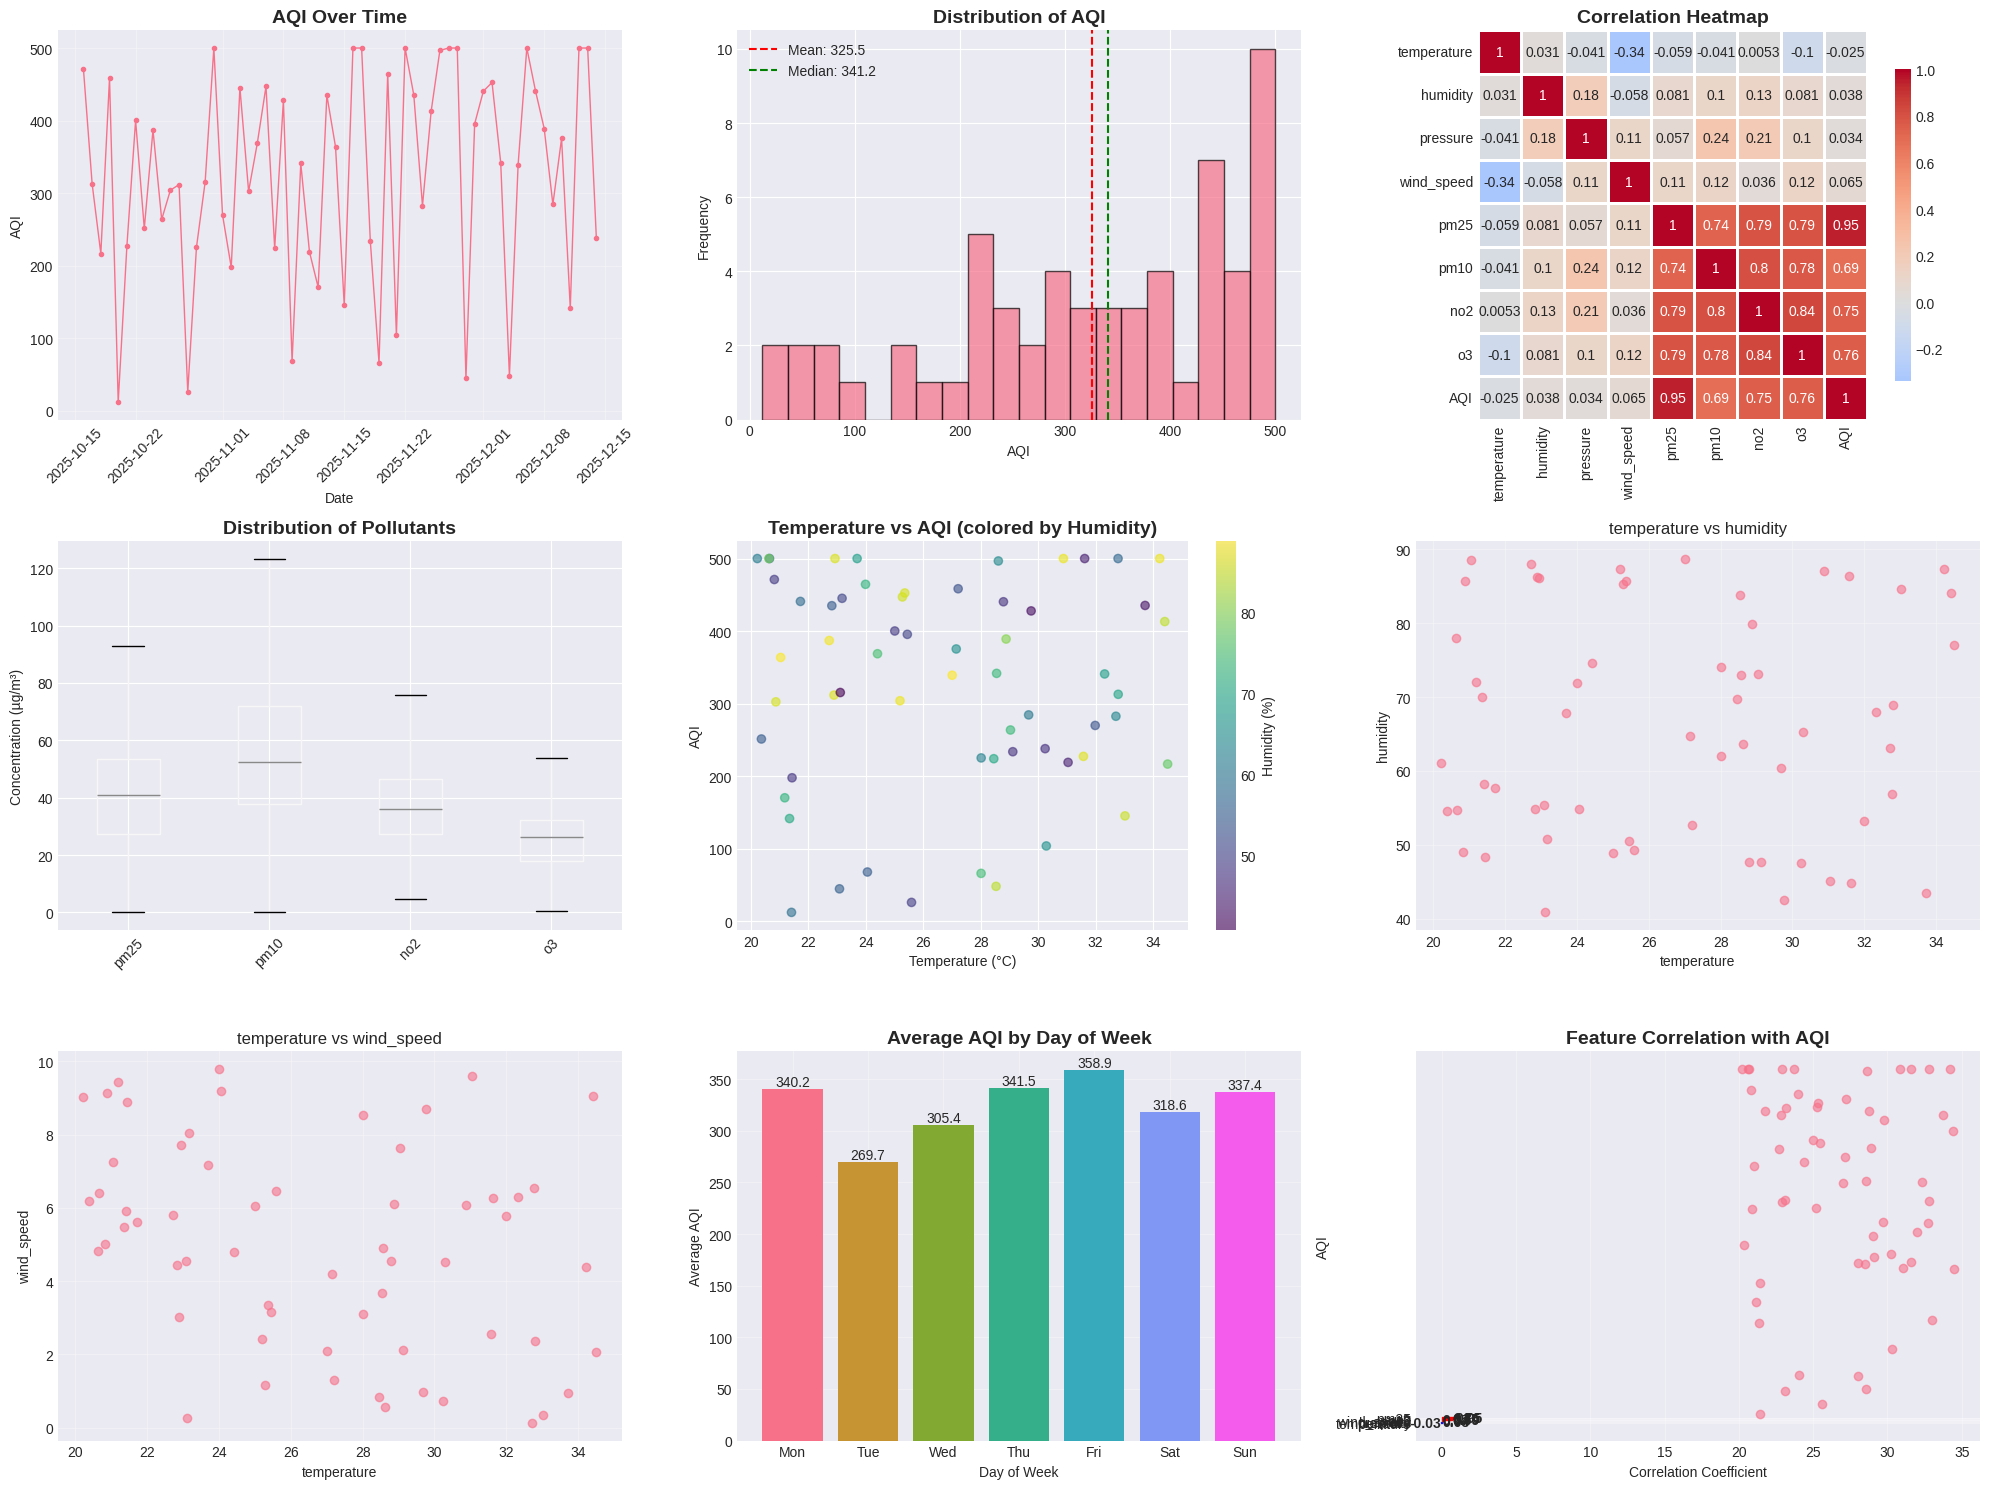


✅ EDA visualizations saved as 'eda_visualizations.png'

KEY INSIGHTS FROM EDA

1. Dataset Statistics:
   • Total records: 60
   • Date range: 2025-10-16 to 2025-12-14
   • Average AQI: 325.5
   • Highest AQI: 500.0
   • Lowest AQI: 12.0

2. Top Correlations with AQI:
   • pm10: 0.687
   • no2: 0.750
   • o3: 0.758
   • pm25: 0.953

3. Pollutant Statistics:
   • PM25: Mean = 41.1, Max = 92.9
   • PM10: Mean = 55.2, Max = 123.3
   • NO2: Mean = 36.7, Max = 75.9
   • O3: Mean = 25.5, Max = 53.7

4. Weather Impact:
   • Temperature vs AQI correlation: -0.025
   • Humidity vs AQI correlation: 0.038
   • Wind Speed vs AQI correlation: 0.065


In [5]:
# Exploratory Data Analysis (EDA)
print("="*50)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*50)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create subplots
fig = plt.figure(figsize=(20, 15))

# 1. Time series of AQI
print("1. Creating time series plot of AQI...")
ax1 = plt.subplot(3, 3, 1)
ax1.plot(merged_df['date'], merged_df['AQI'], marker='o', linestyle='-', linewidth=1, markersize=3)
ax1.set_title('AQI Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('AQI')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Distribution of AQI
print("2. Creating distribution plot of AQI...")
ax2 = plt.subplot(3, 3, 2)
ax2.hist(merged_df['AQI'], bins=20, edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of AQI', fontsize=14, fontweight='bold')
ax2.set_xlabel('AQI')
ax2.set_ylabel('Frequency')
ax2.axvline(merged_df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {merged_df["AQI"].mean():.1f}')
ax2.axvline(merged_df['AQI'].median(), color='green', linestyle='--', label=f'Median: {merged_df["AQI"].median():.1f}')
ax2.legend()

# 3. Correlation heatmap
print("3. Creating correlation heatmap...")
# Select numeric columns for correlation
numeric_cols_for_corr = ['temperature', 'humidity', 'pressure', 'wind_speed',
                         'pm25', 'pm10', 'no2', 'o3', 'AQI']

correlation_data = merged_df[numeric_cols_for_corr].corr()

ax3 = plt.subplot(3, 3, 3)
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax3.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')

# 4. Box plots for pollutants
print("4. Creating box plots for pollutants...")
pollutants = ['pm25', 'pm10', 'no2', 'o3']
boxplot_data = merged_df[pollutants]

ax4 = plt.subplot(3, 3, 4)
boxplot_data.boxplot(ax=ax4)
ax4.set_title('Distribution of Pollutants', fontsize=14, fontweight='bold')
ax4.set_ylabel('Concentration (µg/m³)')
ax4.tick_params(axis='x', rotation=45)

# 5. Scatter plot: Temperature vs AQI
print("5. Creating scatter plot: Temperature vs AQI...")
ax5 = plt.subplot(3, 3, 5)
scatter = ax5.scatter(merged_df['temperature'], merged_df['AQI'],
                     c=merged_df['humidity'], cmap='viridis', alpha=0.6)
ax5.set_title('Temperature vs AQI (colored by Humidity)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Temperature (°C)')
ax5.set_ylabel('AQI')
plt.colorbar(scatter, ax=ax5).set_label('Humidity (%)')

# 6. Pair plot of key features
print("6. Creating pair plot of key features...")
key_features = ['temperature', 'humidity', 'wind_speed', 'pm25', 'AQI']
pairplot_data = merged_df[key_features]

# Create pair plot manually as subplots
from itertools import combinations
feature_pairs = list(combinations(key_features, 2))

for idx, (x_feat, y_feat) in enumerate(feature_pairs[:4], start=6):
    ax = plt.subplot(3, 3, idx)
    ax.scatter(pairplot_data[x_feat], pairplot_data[y_feat], alpha=0.6)
    ax.set_xlabel(x_feat)
    ax.set_ylabel(y_feat)
    ax.set_title(f'{x_feat} vs {y_feat}', fontsize=12)
    ax.grid(True, alpha=0.3)

# 7. Bar plot: AQI by day of week
print("7. Creating bar plot: AQI by day of week...")
ax8 = plt.subplot(3, 3, 8)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
aqi_by_day = merged_df.groupby('day_of_week')['AQI'].mean().reindex(range(7))
bars = ax8.bar(days, aqi_by_day, color=sns.color_palette("husl", 7))
ax8.set_title('Average AQI by Day of Week', fontsize=14, fontweight='bold')
ax8.set_xlabel('Day of Week')
ax8.set_ylabel('Average AQI')

# Add value labels on bars
for bar, value in zip(bars, aqi_by_day):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}', ha='center', va='bottom')

# 8. Feature importance (using correlation with AQI)
print("8. Creating feature importance plot...")
aqi_corr = correlation_data['AQI'].drop('AQI').sort_values(ascending=True)

ax9 = plt.subplot(3, 3, 9)
bars = ax9.barh(range(len(aqi_corr)), aqi_corr.values)
ax9.set_yticks(range(len(aqi_corr)))
ax9.set_yticklabels(aqi_corr.index)
ax9.set_title('Feature Correlation with AQI', fontsize=14, fontweight='bold')
ax9.set_xlabel('Correlation Coefficient')

# Color bars based on correlation value
for bar, value in zip(bars, aqi_corr.values):
    if value > 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

    # Add value label
    ax9.text(value, bar.get_y() + bar.get_height()/2,
            f'{value:.2f}', ha='left' if value > 0 else 'right',
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ EDA visualizations saved as 'eda_visualizations.png'")

# Print key insights
print("\n" + "="*50)
print("KEY INSIGHTS FROM EDA")
print("="*50)

print(f"\n1. Dataset Statistics:")
print(f"   • Total records: {len(merged_df)}")
print(f"   • Date range: {merged_df['date'].min().date()} to {merged_df['date'].max().date()}")
print(f"   • Average AQI: {merged_df['AQI'].mean():.1f}")
print(f"   • Highest AQI: {merged_df['AQI'].max():.1f}")
print(f"   • Lowest AQI: {merged_df['AQI'].min():.1f}")

print(f"\n2. Top Correlations with AQI:")
for feature, corr in aqi_corr.items():
    if abs(corr) > 0.3:
        print(f"   • {feature}: {corr:.3f}")

print(f"\n3. Pollutant Statistics:")
for pollutant in ['pm25', 'pm10', 'no2', 'o3']:
    if pollutant in merged_df.columns:
        print(f"   • {pollutant.upper()}: Mean = {merged_df[pollutant].mean():.1f}, "
              f"Max = {merged_df[pollutant].max():.1f}")

print(f"\n4. Weather Impact:")
print(f"   • Temperature vs AQI correlation: {merged_df['temperature'].corr(merged_df['AQI']):.3f}")
print(f"   • Humidity vs AQI correlation: {merged_df['humidity'].corr(merged_df['AQI']):.3f}")
print(f"   • Wind Speed vs AQI correlation: {merged_df['wind_speed'].corr(merged_df['AQI']):.3f}")

In [6]:
print("DATA PREPARATION FOR MODELING")
print("="*50)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['temperature', 'humidity', 'pressure', 'wind_speed',
            'pm25', 'pm10', 'no2', 'o3', 'day_of_week',
            'temp_humidity', 'wind_pressure']

X = merged_df[features]
y = merged_df['AQI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Features used: {len(features)}")

DATA PREPARATION FOR MODELING
Training samples: 48
Testing samples: 12
Features used: 11


In [7]:
print("MODEL 1: LINEAR REGRESSION")
print("="*50)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")

lr_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\nTop 5 Positive Impact Features:")
print(lr_coefficients.head(5))
print("\nTop 5 Negative Impact Features:")
print(lr_coefficients.tail(5))

MODEL 1: LINEAR REGRESSION
MAE: 37.77
MSE: 3704.52
RMSE: 60.86
R² Score: 0.8058

Top 5 Positive Impact Features:
          Feature  Coefficient
10  wind_pressure   878.743932
4            pm25   135.176024
9   temp_humidity    23.403250
7              o3    10.733109
6             no2     2.768254

Top 5 Negative Impact Features:
       Feature  Coefficient
2     pressure    -6.289543
5         pm10    -8.026653
0  temperature    -9.526759
1     humidity   -27.866817
3   wind_speed  -881.454846


In [8]:
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("="*50)

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

rf_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(rf_feature_importance)

MODEL 2: RANDOM FOREST REGRESSOR
MAE: 8.90
MSE: 202.88
RMSE: 14.24
R² Score: 0.9894

Feature Importance (Random Forest):
          Feature  Importance
4            pm25    0.949810
6             no2    0.020180
7              o3    0.014330
2        pressure    0.005167
5            pm10    0.002445
0     temperature    0.001949
3      wind_speed    0.001373
1        humidity    0.001279
10  wind_pressure    0.001226
9   temp_humidity    0.001216
8     day_of_week    0.001026


In [9]:
print("MODEL 3: XGBOOST REGRESSOR")
print("="*50)

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae_xgb:.2f}")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

xgb_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (XGBoost):")
print(xgb_feature_importance)

MODEL 3: XGBOOST REGRESSOR
MAE: 10.08
MSE: 242.57
RMSE: 15.57
R² Score: 0.9873

Feature Importance (XGBoost):
          Feature    Importance
4            pm25  9.759198e-01
2        pressure  2.006184e-02
3      wind_speed  2.882720e-03
0     temperature  1.101842e-03
1        humidity  3.198389e-05
7              o3  1.335838e-06
5            pm10  2.700326e-07
9   temp_humidity  1.705861e-07
8     day_of_week  6.113845e-08
6             no2  0.000000e+00
10  wind_pressure  0.000000e+00


MODEL COMPARISON
Performance Comparison:
               Model      MAE     RMSE  R² Score Training Time
0  Linear Regression  37.7672  60.8648    0.8058       Fastest
1      Random Forest   8.9011  14.2436    0.9894      Moderate
2            XGBoost  10.0816  15.5746    0.9873          Fast

✅ Best Model: Random Forest with R² Score: 0.9894


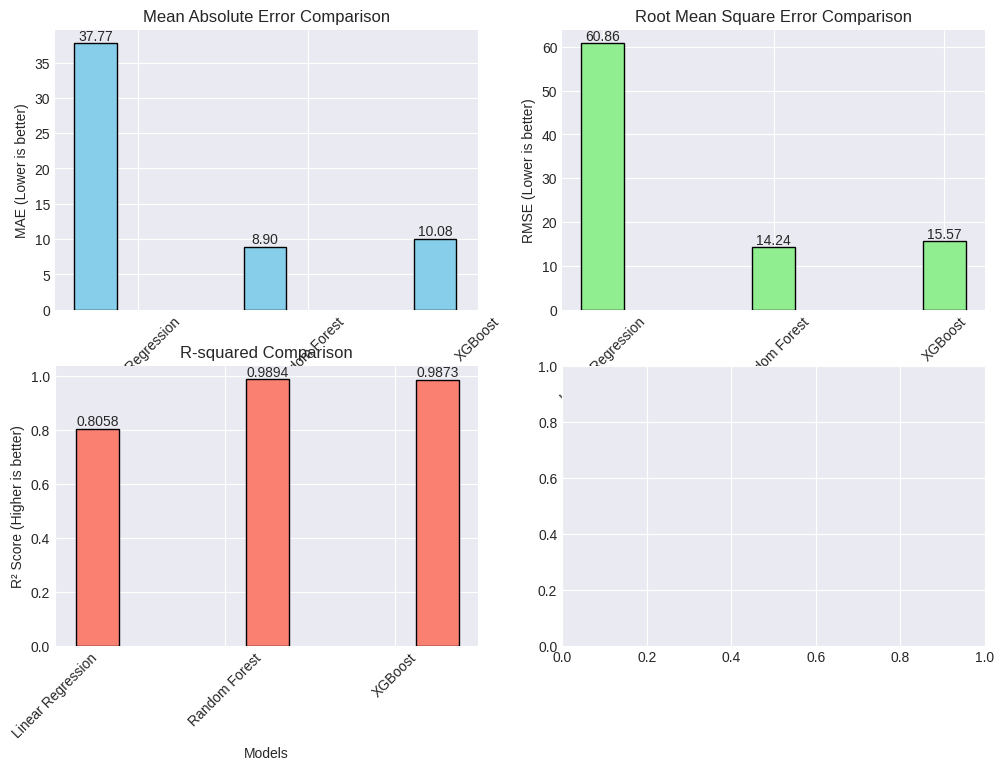

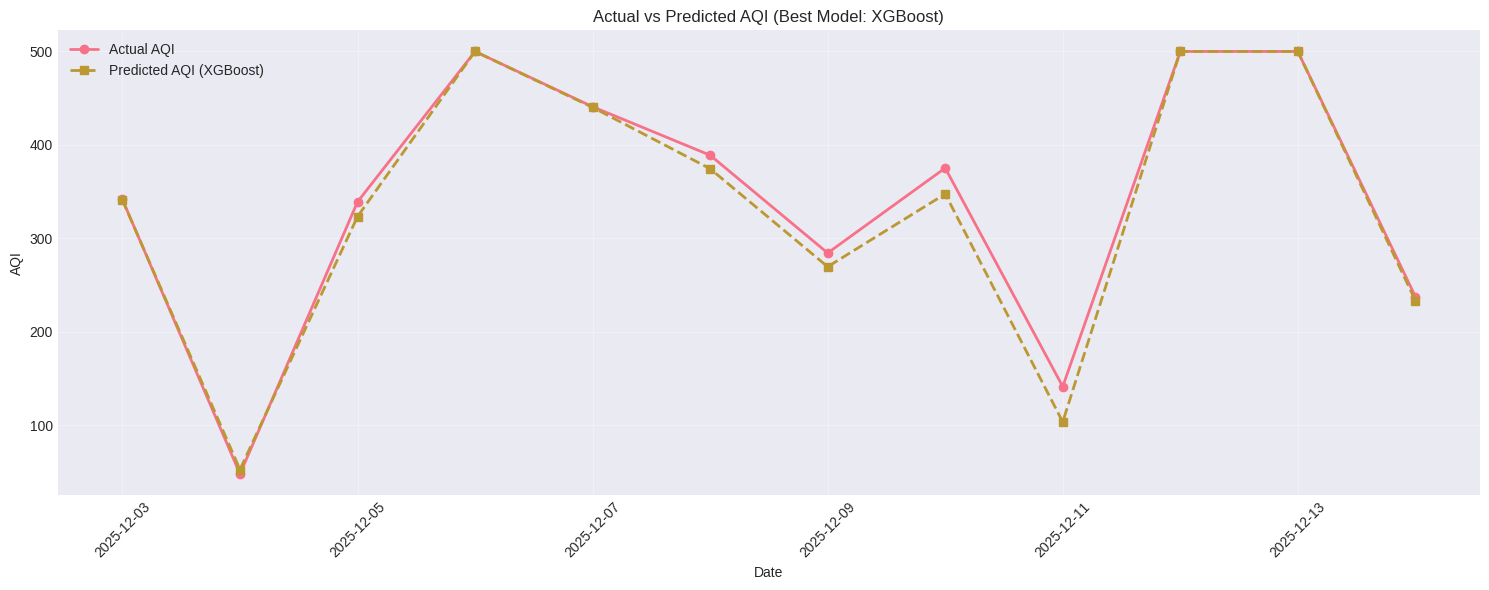


Model comparison visualization saved as 'model_comparison.png'


In [10]:
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R² Score': [r2_lr, r2_rf, r2_xgb],
    'Training Time': ['Fastest', 'Moderate', 'Fast']
})

print("Performance Comparison:")
print(comparison_df.round(4))

best_model_idx = comparison_df['R² Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'R² Score']

print(f"\n✅ Best Model: {best_model} with R² Score: {best_r2:.4f}")

plt.figure(figsize=(12, 8))

x_pos = np.arange(len(comparison_df))
width = 0.25

plt.subplot(2, 2, 1)
bars1 = plt.bar(x_pos - width, comparison_df['MAE'], width, label='MAE', color='skyblue', edgecolor='black')
plt.xlabel('Models')
plt.ylabel('MAE (Lower is better)')
plt.title('Mean Absolute Error Comparison')
plt.xticks(x_pos, comparison_df['Model'], rotation=45)
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.subplot(2, 2, 2)
bars2 = plt.bar(x_pos, comparison_df['RMSE'], width, label='RMSE', color='lightgreen', edgecolor='black')
plt.xlabel('Models')
plt.ylabel('RMSE (Lower is better)')
plt.title('Root Mean Square Error Comparison')
plt.xticks(x_pos, comparison_df['Model'], rotation=45)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.subplot(2, 2, 3)
bars3 = plt.bar(x_pos + width, comparison_df['R² Score'], width, label='R² Score', color='salmon', edgecolor='black')
plt.xlabel('Models')
plt.ylabel('R² Score (Higher is better)')
plt.title('R-squared Comparison')
plt.xticks(x_pos, comparison_df['Model'], rotation=45)
for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')

plt.subplot(2, 2, 4)
test_dates = merged_df['date'].iloc[-len(y_test):].values
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test.values, label='Actual AQI', marker='o', linewidth=2)
plt.plot(test_dates, y_pred_xgb, label='Predicted AQI (XGBoost)', marker='s', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI (Best Model: XGBoost)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel comparison visualization saved as 'model_comparison.png'")